# Анализ причин оттока клиентов  
Цель проекта :  
- сделать прогноз вероятности оттока клиента;  
- формирование типизированного портрета клиентов;  
- провести анализ,влияющих на отток клиентов;
- предложить рекомендации по улучшению качества работы с клиентами;  


Имеем фрейм Churn со следующими данными :  
Данные пользователя за предыдущий до проверки факта оттока месяц:
'gender' — пол  
'Near_Location' — проживание или работа в районе, где находится фитнес-центр  
'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)  
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)  
'Phone' — наличие контактного телефона  
'Age' — возраст  
'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)  
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента  
'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)  
'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)  
'Group_visits' — факт посещения групповых занятий  
'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента  
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц  
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон  

Для анализа данных проведем следующие действия :
1. Проведем анализ входязих даннных;  
2. Исследуем входящие данные на отсутствующие признаки и изучим средние значения, стандартные отклонения;  
3. Исследуем средние значения в группах - тех кто ушли и нет;  
4. Построим столбчатые диаграммы и распределения признаков для тех, кто ушел и тех кто остался;  
5. Построим матрицу корреляции;  
6. Построим модель бинарной классификации пользователей с целевым признаком - факт оттока пользователя в следующем месяце (обучим ее двумя способами - логистической регрессии и случайным лесом)  
7. Проведем класстеризацию пользователей  и посчитаем долю оттока 
8. Дадим рекомендации по улучшения качества работы с клиентами

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# Предобработка данных

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Для удобства последующего анализа приведем названия столбцов к нижнему регистру и столбец с количеством месяцев до окончания абонемента приведем к целочисленному значению . Проверим данные на наличие дубликатов

In [4]:
df.columns = df.columns.str.lower()
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')
df.head(1)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.22747,5,3,0.020398,0.0,0


In [5]:
df.duplicated().sum()

0

Дубликаты и пропуски во входящем фрейме отсутствуют, все столбцы приведены к нужным нам типам

### Исследовательский анализ данных

В данных имеются признаки двух видов, качественные (дающие ответ по принципу да/нет) и количественные. Выделим их и исследуем распределение.

In [6]:
quality_list = [] # список столбцов с качественным признаком
quantitative_list = [] # список количественных
for col in df.columns: 
    if df[col].nunique() > 2:
        quantitative_list.append(col)
    else:
        quality_list.append(col)

In [7]:
df[quality_list].mean()

gender           0.51025
near_location    0.84525
partner          0.48675
promo_friends    0.30850
phone            0.90350
group_visits     0.41225
churn            0.26525
dtype: float64

Для качественных признаков взяли средние значения и получили следующие результаты :  
1) Мужчин и женщин клинтов примерное равное количество
2) Около 85% клиентов проживают или работают не далеко от клуба  
3) 49% имеет скидку на абонемент
4) 30% пришоо по рекомендации   
5) 41% посещает групповые занятия  
6) Отток клиентов составляет 27%

In [8]:
df[quantitative_list].describe()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


Из этих данных имеем следующее :  
1) Среднее дляительность абонемента - 3 месяца (при условии возможных только 1,3,6 и 12 месяцев) 
2) Средний возраст клиентов - 29 лет  
3) в среднем количество посещений в месяц - меньше 2

Посмотрим на разницу в признаках в группах - оставшиеся клиенты и покинувшие клуб

In [9]:
df_difference = df.groupby('churn').mean()
df_difference.T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Для наглядности посмотрим разницу показателей по группым в процентах

In [10]:
df_difference = df_difference.T
df_difference['perc'] = (df_difference[0] / df_difference[1] - 1) * 100
df_difference['perc']

gender                                -0.156880
near_location                         13.661882
partner                               50.339846
promo_friends                         92.352012
phone                                  0.087158
contract_period                      232.484825
group_visits                          72.776753
age                                   11.066806
avg_additional_charges_total          37.679635
month_to_end_contract                217.764056
lifetime                             375.663839
avg_class_frequency_total             37.280201
avg_class_frequency_current_month     94.140088
Name: perc, dtype: float64

Разница практически отсутствует в двух признаках - пол и наличие телефона. Во всех остальных пунктах - значимые различия, особо выделим параметры связанные с длительностью контракта

Построим столбчатые диаграммы:  
1) Для качественных возьмем относительные значения(т.к. в количестве ушедших и оставшихся людей существенная разница)  
2) Для количественных построим гистограммы с распределением

In [11]:
quality_list.remove('churn')
quality_list

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'group_visits']

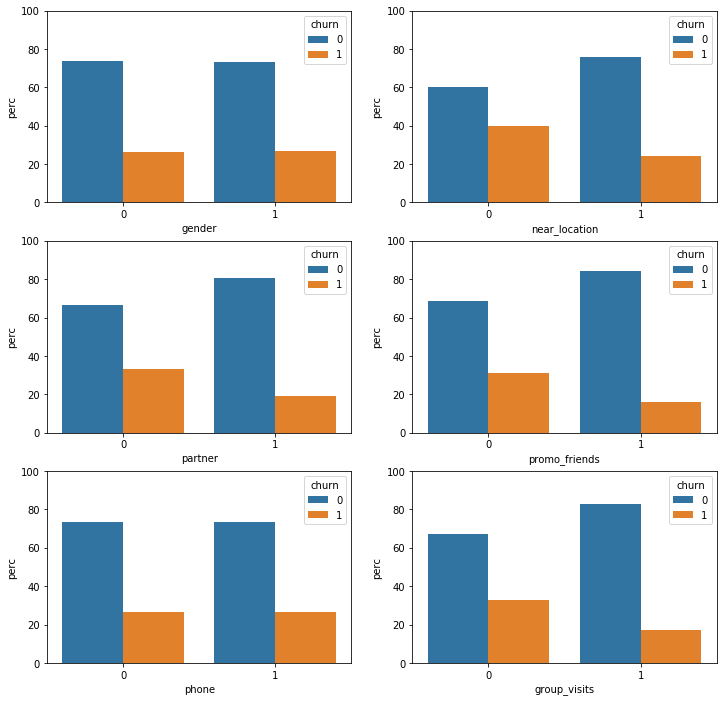

In [12]:
f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, quality_list):
    percent = (df.groupby(col)['churn']
                     .value_counts(normalize=True).mul(100)
                     .rename('perc').reset_index())
    sns.catplot(x=col, y='perc', hue='churn',kind='bar',
              data=percent,  ax=ax)
    ax.set(ylim = (0,100))
    plt.close(2)
plt.show()

Из диаграмм получаем результаты озвученные ранее только два признака (пол и телефон) не влияют на отток клиентов. Остальное сильно различаются для двух рассматриваемых групп. Для тех кто остались характерно следующее:
1) Они живут или работаю рядом с клубом;
2) Участвуют по партнерской программе или с рекомендации друга;
3) Наиболее активно посещают групповые занятия

In [13]:
quantitative_list.remove('lifetime')

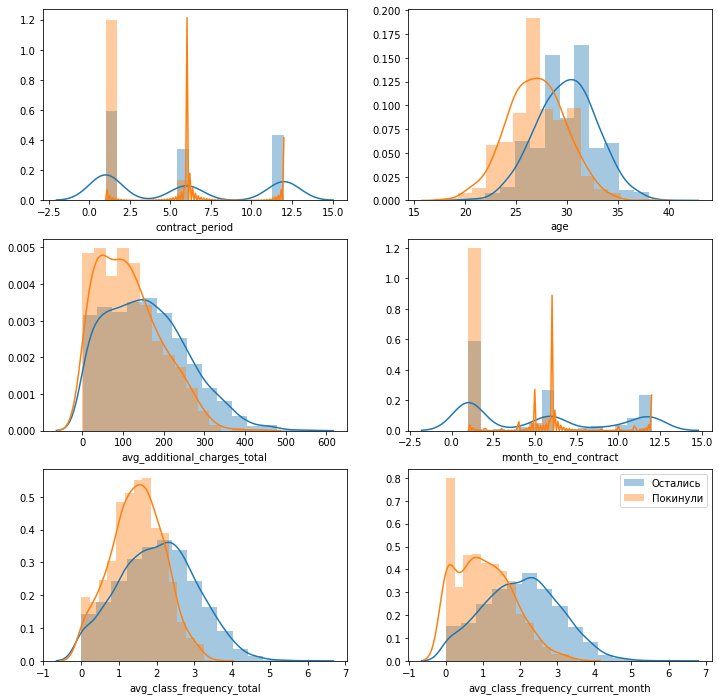

In [14]:
f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, quantitative_list):
    sns.distplot(df.query('churn==0')[col], bins=15,ax=ax, label ='Остались')
    sns.distplot(df.query('churn==1')[col], bins=15,ax=ax, label ='Покинули')
    ax.set(xlabel=col)
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.))
plt.show()

Из полученных графиков видно , что для ушедших клиентов характерно следующее :  
1) меньшее количество : посещений, трат на доп. услуги  
2) меньше срок контракта (в среднем)  
3) в среднем моложе

Построим матрицу корреляций

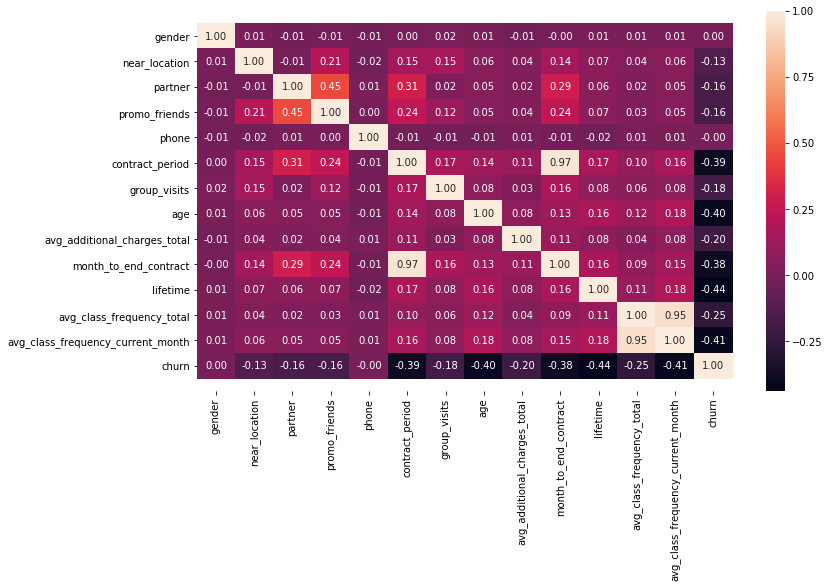

In [15]:
corr = df.corr()
f, ax = plt.subplots(figsize = (12,7))
ax = sns.heatmap(corr, xticklabels = corr.columns, fmt='.2f', 
                 yticklabels = corr.columns, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Из матрицы корреляций видно, что на отток пользователей больше всего влияет - длительность контракта (и параметров связанных с этим), возраст, посещение групповых занятий

Из интересных зависимостей - партнерка и приведи друга сильно влияют на все характеристики контрактов связанные со временем (что скорее всего обуславливается минимальны сроком возможного заключения договора или просто это становится еще выгодней с этими акциями).  
Более интересных связей между остальными признаками не наблюдаю (связьмежду длительностью контракта и временем до окончания его же не считаю интересной)

# Модель прогнозирования оттока пользователей

In [16]:
# разделим наши данные на признаки 
X = df.drop(columns = ['churn']) # матрица 
y = df['churn'] # целевую переменную

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.2)

Спасибо, учту и впредь

Для оптимизации созданим функцию для выведения метрик

In [17]:
def print_metric(y_test, y_pred, text):
    print(text)
    print('\tAccuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('\tPrecision: {:.3f}'.format(precision_score(y_test, y_pred)))
    print('\tRecall: {:.3f}'.format(recall_score(y_test, y_pred)))

Логистическая регрессия

In [18]:
lr_model = LogisticRegression(max_iter = 3000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print_metric(y_test, y_pred_lr, text = 'Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.934
	Precision: 0.906
	Recall: 0.843


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Модель с лесом

In [19]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print_metric(y_test, y_pred_rf, text = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.922
	Precision: 0.874
	Recall: 0.834


При заданных параметрах модель логистической регрессии проявила себя лучше

## Кластеризация параметров

Стандартизируем даные

In [20]:
sc = StandardScaler()
x_sc_4 = sc.fit_transform(df.drop(columns = ['churn']))

Построим матрицу расстояний и нарисуем дендрограмму

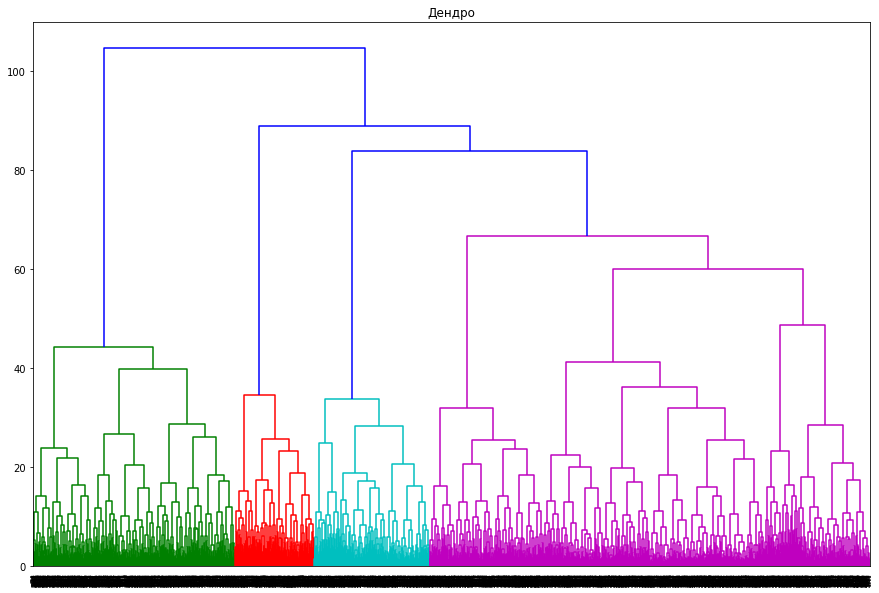

In [21]:
linked = linkage(x_sc_4, method = 'ward')
# график кластеризации
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендро')
plt.xticks(rotation=90)
plt.show()

Обучение модели на основании алгоритма  K-means

In [22]:
km = KMeans(n_clusters = 5, random_state = 1)
labels = km.fit_predict(x_sc_4)

Рассмотрим средние значения по кластерам

In [23]:
df['cluster'] = labels
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.500960,0.519319,0.498371,0.505426,0.523316
near_location,0.000000,1.000000,0.951140,1.000000,0.862694
partner,0.464491,0.224623,0.739414,0.773643,0.471503
promo_friends,0.078695,0.000000,0.466884,1.000000,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,2.343570,2.056974,11.511401,2.972093,4.777202
group_visits,0.216891,0.379175,0.543974,0.451163,0.427461
age,28.579655,28.918140,29.964169,29.120930,29.297927
avg_additional_charges_total,136.561586,141.863877,166.325823,141.317434,144.208179
month_to_end_contract,2.197697,1.963982,10.457112,2.778295,4.466321


Сразу можно сделать следующие выводы :  
1) Кластер 2 - наименьшая вероятность оттока  (наиболее надежный)  
2) Кластер 0 и 1 - наибольшая вероятность оттока  (склонны к оттоку)  
3) Кластер 4  - клиенты без указанного номера   
4) Кластер 1 и 3 - все клиенты живут или работают рядом  с клубом  

Построим распределение признаков по кластерам

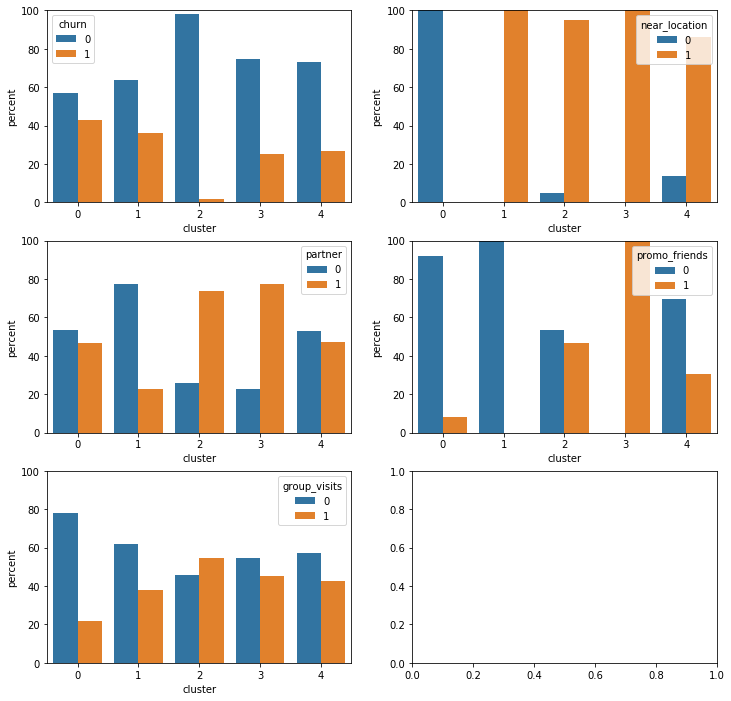

In [24]:
list_for_clust = ['churn', 'near_location', 'partner', 'promo_friends', 'group_visits']

f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, list_for_clust):
    percent = (df.groupby('cluster')[col]
                     .value_counts(normalize=True).mul(100)
                     .rename('percent').reset_index())
    sns.catplot(x='cluster', y='percent', hue=col,kind='bar',
              data=percent,  ax=ax)
    ax.set(ylim = (0,100))
    plt.close(2)
plt.show()

На графиках явно заметно следующее :  
1) Ранее было указано что в кластера 1 и 2 наибольший отток клиентов - теперь также заметно, что в этих кластерах наибольшее количество клиентов пришедших по промо акциям  (партнеры или друзья)  
2) Кластер 0 и 1 - наименьшее количество посещений групповых занятий

### Дополнение  
Давно коробочки не использовал, по моему достаточно удобно для рассмотрения параметров по кластерам.

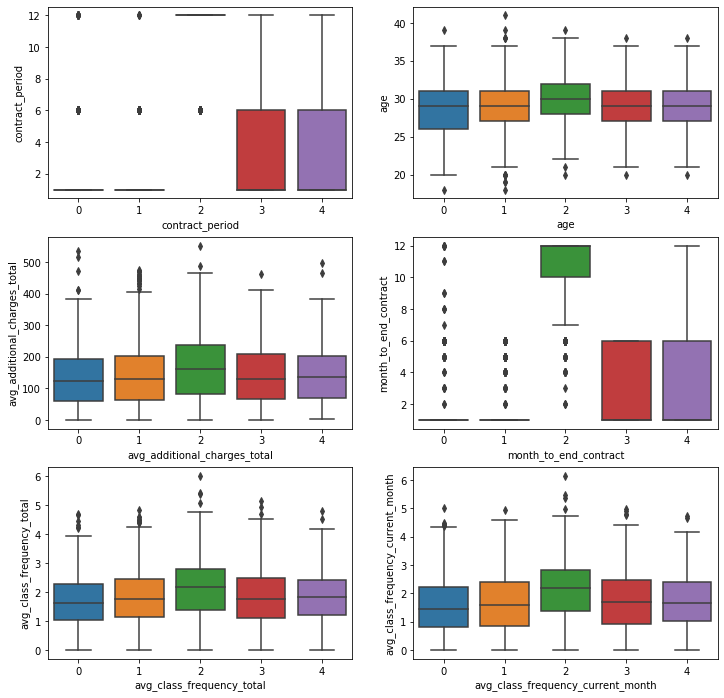

In [25]:
f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, quantitative_list):
    sns.boxplot(x = 'cluster', y = col, data=df,ax=ax)
    ax.set(xlabel=col)
plt.show()

Из распределения можем сделать выводы (кластер 2 вообще по количественным параметрам как то обходит всех ) :  
1) Максимальный возраст (как и средний) в кластере 2   
2) Наибольшие доп. траты наблюдаются в кластере 2  
3) Наибольшаячастота посещения в кластере 2  
4) Самая низкая посещаемость в кластере 0 

(каюсь описание кластеров не самая интересная часть хадания, поэтому предпочту описать характеристики надежных кластеров)  
Клиенты с меньшей вероятностью прекратят свои занятия если они удовлетворяют следующим признакам :  
- воспользовался партнеркой или акцией приведи друга  
- чем старше человек , тем выше шансы что он на долго в клубе  
- высокая частота посещений клуба на самомстоятельные занятия или групповые (а если человек - машина то и там и там)  
- пользуется доп. услугшами клуба (в группах с высоким показателем оттока этот показатель ниже чем в устойчивых)  
- работает или живет не далеко от клуба  
- заключен длительный контракт с клубом   


# Выводы   
Во время проведения анализа были выявлены основные причины оттока клиентов :  
1) меньший возраст  
2) проживание/работа далеко от фитнес-центра  
3) короткий контракт  
4) уходящие клиенты реже заключали договор по партнерской программе  

Для клиенты которые постоянно посещают клуб соответствуют диаметрально противоположные характеристики - близкое расположение от клуба, больший возраст, длительно заключенный контракт, более высокие затраты на доп. услуги клуба.  
  
Из портрета посстоянных клиентов делаем выводы для рекомендаций по улучшению стратегии взаимодействия с клиентами :  
1) Выделять клиентов количество которых в неделю начинает падать и делать им персональные предложения, для повышения интереса посещения клуба  
2) Усилить продвижение программ лояльности и акций - клиенты пришедшие по ним остаются и посещают клуб на много дольше  
3) В предложении новым клиентам делать упор на контракты более длительного периода (за счет скидок, акций или доп. предложений)